## Prelab 6

In [1]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"

# Define Tesla
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

In [25]:
# Known values
B_max = 0.3 * units.tesla
D_max = 0.35 # Duty Cycle Max
I_rms_cu = 10 * units.amp / (units.mm)**2 # rms
Vo = 10 * units.volt
Vg = 18 * units.volt
alpha = 0.8
Ro = 5 * units.ohm
Mo = Vo/Vg
fs = 50 * units.kilohertz
Ts = 1/fs

A_cmin = 59.1 * (units.mm)**2
A_coil = (11.1/2 * units.mm)**2 * math.pi


Lg_inches = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,
                      0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019,
                      0.020, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027]) # inches

Lg = Lg_inches*25.4*units.mm

wires = {
    0.82 * (units.mm)**2: 18,
    0.52 * (units.mm)**2: 20,
    0.33 * (units.mm)**2: 22,
    0.20 * (units.mm)**2: 24 
} # mm^2: awg

u_o = 1.2566 * 10**(-6) * units.newton/(units.amp)**2  # free space (we only need this value)
u_r = 3300 * 10**(-6) * units.newton/(units.amp)**2

In [3]:
# Current calculation and wire sizing

a = (Vo/Vg) * (np.sqrt(alpha) - D_max)/D_max
print(f"Our transformer turn ratio is 1:a, where a is {a}.")
M = Mo/a
R = Ro/(a**2)
V = Vo/a


I_pk = 2/np.sqrt(alpha) * (M+1) * (V/R)
Io_pk = I_pk / a

I_rms = math.sqrt(D_max/3) * I_pk
Io_rms = math.sqrt(D_max/3) * Io_pk

min_wire_area = max([I_rms/I_rms_cu, Io_rms/I_rms_cu])
wire_gauge=0

for area in wires:
    if area > min_wire_area:
        wire_gauge = wires[area]
        
print("Min wire gauge:", wire_gauge)

Our transformer turn ratio is 1:a, where a is 0.864170144444311.
Min wire gauge: 22


In [22]:
# Calculate flux max and relevant values
L_crit = ((1/(M+1))**2 * R * Ts / 2).to("henry").to_compact()
L_goal = alpha * L_crit
print(f"Our goal magnetizing inductance will be {np.round(L_goal, 3)}.")

phi_max = A_cmin * B_max
print("Phi_max:", phi_max)
min_turns = ((L_goal*I_pk)/phi_max).to_base_units()
print("Min turns:", math.ceil(min_turns), "turns")
print(f"For turns ratio, 1 : {a.magnitude:.3f} will approximately be {math.ceil(min_turns)} : {math.ceil(min_turns*a)}")

W_max = 0.5 * Lg * I_pk**2

Our goal magnetizing inductance will be 19.845 µH.
Phi_max: 17.73 T·mm²
Min turns: 8 turns
For turns ratio, 1 : 0.864 will approximately be 8 : 7


In [26]:
# 2 * outer area + inner area
area_finder = lambda t: 2 * ((2*(7+t)*(10.65+t) - (7+t)*math.sqrt((9-t)**2 - (7+t)**2) - (9 - t)**2 * math.asin((7+t)/(9-t)))) + (np.pi*(8.8/2 + t)**2)
reluctance_finder = lambda t: (2*t)/(u_o*10**(-3)*area_finder(t)*((units.amp)**2)/units.newton)
vfunc = np.vectorize(reluctance_finder)
R = vfunc(Lg)
N = np.sqrt(np.multiply(L_goal,R))

# B = N*I_rms*u_o incorrect
F = N*I_rms
phi = np.divide(F, R)
B = phi / A_coil
W = 0.5 * np.multiply(np.power(phi, 2), R)

/home/lila/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2433: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  otypes = ''.join([asarray(outputs[_k]).dtype.char
/home/lila/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2453: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  inputs = [asanyarray(a, dtype=object) for a in args]


/home/lila/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/tmp/ipykernel_64704/889201168.py:27: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  fig.legend(["Floor turns", "Ceiling turns", "20 uH limit", '_nolegend_', '_nolegend_', '_nolegend_', "N_min = 5 turns", "Selected Design"], bbox_to_anchor=(1.2, 0.9))


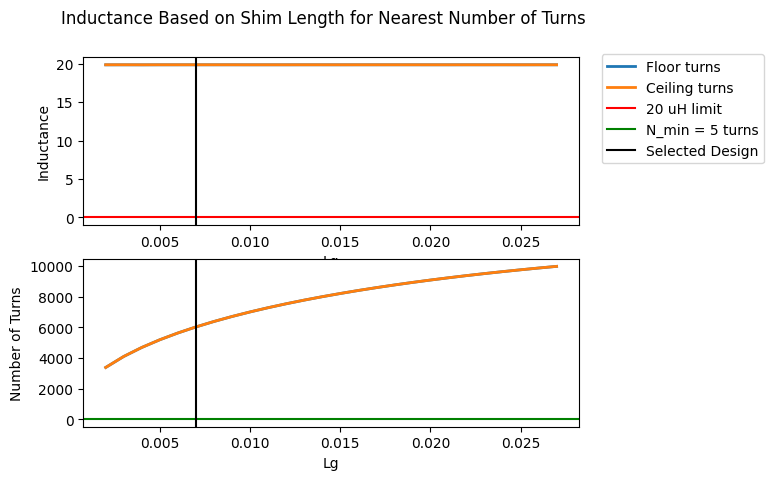

In [27]:
N_Floor = np.floor(N)
N_Ceiling = N_Floor.magnitude + 1

L_Possible = np.divide(np.power(N_Floor,2),R)
L_Ceiling = np.divide(np.power(N_Ceiling,2),R)

fig, ax = plt.subplots(2)
fig.suptitle("Inductance Based on Shim Length for Nearest Number of Turns")
# print(N_Floor)
# print(L_Possible)

ax[0].plot(Lg_inches,L_Possible, linewidth=2.0, label="Floor Number of Turns")
ax[0].plot(Lg_inches,L_Ceiling, linewidth=2.0)
ax[0].axhline(y = 2.0e-05, color = 'r', linestyle = '-') 
ax[0].axvline(x = 0.007, color = 'k', linestyle = '-')
ax[0].set_ylabel("Inductance")
ax[0].set_xlabel("Lg")

ax[1].plot(Lg_inches, N_Floor, linewidth=2.0)
ax[1].plot(Lg_inches, N_Ceiling, linewidth=2.0)
ax[1].axhline(y = 5, color = 'g', linestyle = '-')

ax[1].axvline(x = 0.007, color = 'k', linestyle = '-')
ax[1].set_ylabel("Number of Turns")
ax[1].set_xlabel("Lg")

fig.legend(["Floor turns", "Ceiling turns", "20 uH limit", '_nolegend_', '_nolegend_', '_nolegend_', "N_min = 5 turns", "Selected Design"], bbox_to_anchor=(1.2, 0.9))
